# Demo

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from nodevectors import Node2Vec
import xgboost as xgb
from fucc.inductive_step import inductive_pooling
from fucc.metrics import plot_ap, get_optimal_f1_cutoff, get_confusion_matrix
from sklearn.metrics import average_precision_score
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# Parameters
dimensions = 128
walk_len = 80
walk_num = 10
window_size = 5
workers = 6

## Load Data

In [3]:
##### TEMPORARY
input_path = '/Users/raf/Dropbox/DOC/data/fucc_simple_rolling_window/demo_data'

#####

In [4]:
df_train = pd.read_csv(os.path.join(input_path, 'df_demo_train.csv'), parse_dates=[7])
df_train = df_train.set_index(df_train.columns[0])

df_test = pd.read_csv(os.path.join(input_path,'df_demo_test.csv'), parse_dates=[7])
df_test = df_test.set_index(df_test.columns[0])

In [5]:
df_train = df_train.drop(['TX_DATETIME'], axis=1)
df_test = df_test.drop(['TX_DATETIME'], axis=1)

In [6]:
df_train = df_train.iloc[:1000]
df_test = df_test.iloc[:1000]

## Create network

In [7]:
G = nx.Graph()
G.add_nodes_from(df_train.TERM_MIDUID.unique(), type='merchant')
G.add_nodes_from(df_train.CARD_PAN_ID.unique(), type='cardholder')
G.add_nodes_from(df_train.TX_ID.unique(), type='transaction')

G.add_edges_from(zip(df_train.CARD_PAN_ID, df_train.TX_ID))
G.add_edges_from(zip(df_train.TX_ID, df_train.TERM_MIDUID))

## Deepwalk

In [8]:
# Fit embedding model to graph
g2v = Node2Vec(
    n_components=dimensions,
    walklen = walk_len,
    epochs = walk_num,
    w2vparams={'workers': workers, 'window': window_size}
)

g2v.fit(G)
model = g2v.model

Making walks... Done, T=2.87
Mapping Walk Names... 

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 800000 words, keeping 2199 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 1600000 words, keeping 2199 word types
INFO:gensim.models.word2vec:collected 2199 word types from a corpus of 1759200 raw words and 21990 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=5 retains 2199 unique words (100% of original 2199, drops 0)
INFO:gensim.models.word2vec:effective_min_count=5 leaves 1759200 word corpus (100% of original 1759200, drops 0)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 2199 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 16 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 1677923 word corpus (95.4% of pr

Done, T=0.80
Training W2V... 

INFO:gensim.models.base_any2vec:training model with 12 workers on 2199 vocabulary and 128 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker 

Done, T=2.87


In [9]:
embeddings = {}
for i in df_train.TX_ID:
    embeddings[i] = model.wv[str(i)]


embeddings = pd.DataFrame().from_dict(embeddings, orient='index')

In [10]:
df_train = df_train.merge(embeddings, left_on='TX_ID', right_index=True)

## Inductive Pooling

In [11]:
results = inductive_pooling(df=df_test, embeddings=embeddings, G=G, workers=workers)

100%|██████████| 166/166 [00:00<00:00, 495.14it/s]

100%|██████████| 167/167 [00:00<00:00, 444.36it/s]


In [12]:
df_new_embeddings = pd.concat([pd.DataFrame(li).transpose() for li in results])

In [13]:
df_new_embeddings.index = df_test.TX_ID
df_test = df_test.merge(df_new_embeddings, left_on='TX_ID', right_index=True)

## XGBoost Classifier

In [14]:
embedding_features = [i for i in range(dimensions)]

In [15]:
X_train = df_train[embedding_features].iloc[:int(df_train.shape[0]*0.8)]
X_val = df_train[embedding_features].iloc[int(df_train.shape[0]*0.8):]
y_train = df_train.TX_FRAUD.iloc[:int(df_train.shape[0]*0.8)]
y_val = df_train.TX_FRAUD.iloc[int(df_train.shape[0]*0.8):]

X_test = df_test[embedding_features]
y_test = df_test.TX_FRAUD

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [16]:
xgb_params = {
    'eval_metric': ['auc','aucpr', 'logloss'],
    'objective':'binary:logistic',
    'n_estimators': 300,
    'n_jobs':8,
    'learning_rate':0.1,
    'seed':42
}

In [17]:
model = xgb.train(xgb_params, dtrain, num_boost_round=xgb_params['n_estimators'], evals=[(dval, 'val'), (dtrain, 'train')], early_stopping_rounds=int(xgb_params['n_estimators']/2))

[18:44:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	val-auc:0.73737	val-aucpr:0.09467	val-logloss:0.60193	train-auc:0.99435	train-aucpr:0.25000	train-logloss:0.59983
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 150 rounds.
[1]	val-auc:0.73106	val-aucpr:0.09320	val-logloss:0.52746	train-auc:0.99812	train-aucpr:0.80751	train-logloss:0.52338
[2]	val-auc:0.73232	val-aucpr:0.13466	val-logloss:0.46467	train-auc:0.99937	train-aucpr:0.88733	train-logloss:0.45953
[3]	val-auc:0.72854	val-aucpr:0.13414	val-logloss:0.41200	train-auc:0.99937	train-aucpr:0.88733	train-l

[65]	val-auc:0.75379	val-aucpr:0.50755	val-logloss:0.03588	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00424
[66]	val-auc:0.75379	val-aucpr:0.50755	val-logloss:0.03603	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00411
[67]	val-auc:0.75379	val-aucpr:0.50755	val-logloss:0.03620	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00398
[68]	val-auc:0.72601	val-aucpr:0.50680	val-logloss:0.03635	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00387
[69]	val-auc:0.75884	val-aucpr:0.50771	val-logloss:0.03610	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00375
[70]	val-auc:0.75379	val-aucpr:0.50755	val-logloss:0.03626	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00365
[71]	val-auc:0.75126	val-aucpr:0.50748	val-logloss:0.03642	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00354
[72]	val-auc:0.72854	val-aucpr:0.50686	val-logloss:0.03658	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00345
[73]	val-auc:0.72854	val-aucpr:0.50686	val-loglo

[134]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03866	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[135]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03866	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[136]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03866	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[137]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03867	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[138]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03867	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[139]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03867	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[140]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03867	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[141]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03868	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[142]	val-auc:0.73106	val-aucpr:0.50692	

[203]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03870	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[204]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03870	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[205]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03870	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[206]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03870	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[207]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03870	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[208]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03870	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[209]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03870	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[210]	val-auc:0.73106	val-aucpr:0.50692	val-logloss:0.03870	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.00285
[211]	val-auc:0.73106	val-aucpr:0.50692	

In [18]:
y_pred_proba = model.predict(dtest)

## Evaluation

In [19]:
ap = average_precision_score(y_test, y_pred_proba)
print("Average Precision: ", np.round(ap,2))

Average Precision:  0.01


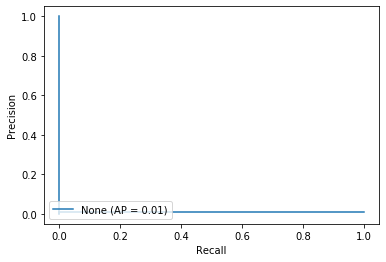

In [20]:
fig = plot_ap(y_test, y_pred_proba)

In [21]:
optimal_threshold, optimal_f1_score = get_optimal_f1_cutoff(y_test, y_pred_proba)
print("F1 Score: ", np.round(optimal_f1_score, 4))

F1 Score:  0.0178


In [22]:
cm = get_confusion_matrix(y_test, y_pred_proba, optimal_threshold)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[  0 991]
 [  0   9]]
